<a href="https://colab.research.google.com/github/shank10/Gemma/blob/main/ompany_financial_duedilligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install required libraries
!pip install cohere hnswlib unstructured llmsherpa

In [ ]:
#Enable text wrapping in Google Colab

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Parsing Documents

In [ ]:
# Parsing pdfs
from llmsherpa.readers import LayoutPDFReader

llmsherpa_api_url = "https://readers.llmsherpa.com/api/document/developer/parseDocument?renderFormat=all"
pdf_url = "/content/Apple_10-k.pdf"
pdf_reader = LayoutPDFReader(llmsherpa_api_url)
doc = pdf_reader.read_pdf(pdf_url)

### Importing Cohere and setting up

In [ ]:
import cohere
import uuid
import hnswlib
from typing import List, Dict
from unstructured.partition.html import partition_html
from unstructured.chunking.title import chunk_by_title

In [ ]:
from google.colab import userdata
co_key = userdata.get("Add cohore API key here")
if not co_key:
  print("co_key not set in environment variables")

co = cohere.Client(co_key)

In [ ]:
#print(doc)
import numpy as np

### Defining Vector Store

In [ ]:
class Vectorstore:

    def __init__(self, doc):
        self.docs = []
        self.docs_embs = []
        self.retrieve_top_k = 10
        self.rerank_top_k = 5
        self.load_and_chunk()
        self.embed()
        self.index()


    def load_and_chunk(self) -> None:
        """
        Loads the text from the source and chunks the content.
        """
        print("Loading documents...")

        for chunk in doc.chunks():
             self.docs.append(
                 {
                     "title": "Apple 10-K 2023",
                     "text": str(chunk.to_context_text()),
                     "url": df_url,
                 }
             )

    def embed(self) -> None:
        """
        Embeds the document chunks.
        """
        print("Embedding document chunks...")

        batch_size = 90
        self.docs_len = len(self.docs)
        for i in range(0, self.docs_len, batch_size):
            batch = self.docs[i : min(i + batch_size, self.docs_len)]
            texts = [item["text"] for item in batch]
            docs_embs_batch = co.embed(
                texts=texts, model="embed-english-v3.0", input_type="search_document"
            ).embeddings
            self.docs_embs.extend(docs_embs_batch)

    def index(self) -> None:
        """
        Indexes the document chunks for efficient retrieval.
        """
        print("Indexing document chunks...")

        self.idx = hnswlib.Index(space="ip", dim=1024)
        self.idx.init_index(max_elements=self.docs_len, ef_construction=512, M=64)
        self.idx.add_items(self.docs_embs, list(range(len(self.docs_embs))))

        print(f"Indexing complete with {self.idx.get_current_count()} document chunks.")

    def retrieve(self, query: str) -> List[Dict[str, str]]:
        """
        Retrieves document chunks based on the given query.

        """

        # Dense retrieval
        query_emb = co.embed(
            texts=[query], model="embed-english-v3.0", input_type="search_query"
        ).embeddings

        doc_ids = self.idx.knn_query(query_emb, k=self.retrieve_top_k)[0][0]

        # Reranking
        rank_fields = ["title", "text"]

        docs_to_rerank = [self.docs[doc_id] for doc_id in doc_ids]

        rerank_results = co.rerank(
            query=query,
            documents=docs_to_rerank,
            top_n=self.rerank_top_k,
            model="rerank-english-v3.0",
            rank_fields=rank_fields
        )

        doc_ids_reranked = [doc_ids[result.index] for result in rerank_results.results]

        docs_retrieved = []
        for doc_id in doc_ids_reranked:
            docs_retrieved.append(
                {
                    "title": self.docs[doc_id]["title"],
                    "text": self.docs[doc_id]["text"],
                    "url": self.docs[doc_id]["url"],
                }
            )

        return docs_retrieved

In [ ]:
#Creating vector store

vectorstore = Vectorstore(doc)

Loading documents...
Embedding document chunks...
Indexing document chunks...
Indexing complete with 574 document chunks.


### Test retrieval

In [ ]:
vectorstore.retrieve("iPhone sales")

[{'title': 'Apple 10-K 2023',
  'text': 'Products and Services Performance\niPhone iPhone net sales decreased 2% or $4.9 billion during 2023 compared to 2022 due to lower net sales of non-Pro iPhone models, partially offset by higher net sales of Pro iPhone models.',
  'url': '/content/Apple_10-k.pdf'},
 {'title': 'Apple 10-K 2023',
  'text': 'Products and Services Performance\n |  | 2023 | Change | 2022 | Change | 2021\n | --- | --- | --- | --- | --- | ---\n | Net sales by category: iPhone (1) | $ 200,583 | (2)% | $ 205,489 | 7 % | $ 191,973\n | Mac (1) | 29,357 | (27)% | 40,177 | 14 % | 35,190\n | iPad (1) | 28,300 | (3)% | 29,292 | (8)% | 31,862\n | Wearables, Home and Accessories | 39,845 | (3)% | 41,241 | 7 % | 38,367\n | (1)\n | (2)\n | Services | 85,200 | 9 % | 78,129 | 14 % | 68,425\n | Total net sales | $ 383,285 | (3)% | $ 394,328 | 8 % | $ 365,817\n',
  'url': '/content/Apple_10-k.pdf'},
 {'title': 'Apple 10-K 2023',
  'text': 'Notes to Consolidated Financial Statements > No

### Creating chatbot instance

In [ ]:
class Chatbot:
    def __init__(self, vectorstore: Vectorstore):
        self.vectorstore = vectorstore
        self.conversation_id = str(uuid.uuid4())

    def run(self):

        while True:

            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
              print("Ending chat.")
              break

            # Generate search queries (if any)
            response = co.chat(message=message,
                               model="command-r",
                               search_queries_only=True)

            # If there are search queries, retrieve document chunks and respond
            if response.search_queries:
                print("Retrieving information...", end="")

                # Retrieve document chunks for each query
                documents = []
                for query in response.search_queries:
                    documents.extend(self.vectorstore.retrieve(query.text))

                # Use document chunks to respond
                response = co.chat_stream(
                    message=message,
                    model="command-r-plus",
                    documents=documents,
                    conversation_id=self.conversation_id,
                )

            # If there is no search query, directly respond
            else:
                response = co.chat_stream(
                    message=message,
                    model="command-r-plus",
                    conversation_id=self.conversation_id,
                )

            # Print the chatbot response, citations, and documents
            print("\nChatbot:")
            citations = []
            cited_documents = []

            # Display response
            for event in response:
                if event.event_type == "text-generation":
                    print(event.text, end="")
                elif event.event_type == "citation-generation":
                    citations.extend(event.citations)
                elif event.event_type == "stream-end":
                    cited_documents = event.response.documents

            # Display citations and source documents
            if citations:
              print("\n\nCITATIONS:")
              for citation in citations:
                print(citation)

              print("\nDOCUMENTS:")
              for document in cited_documents:
                print(document)

            print(f"\n{'-'*100}\n")

In [ ]:
# Create an instance of the Chatbot class
chatbot = Chatbot(vectorstore)

# Run the chatbot
chatbot.run()

User: What happened to iPhone sales in 2023? Explain by region
Retrieving information...
Chatbot:
In 2023, iPhone sales decreased by 2% or $4.9 billion compared to 2022. This was due to lower net sales of non-Pro iPhone models, partially offset by higher net sales of Pro iPhone models.

Here is a breakdown of iPhone sales performance by region in 2023 compared to 2022:
- Americas: iPhone sales decreased, contributing to a 4% or $7.1 billion decrease in net sales for the region.
- Europe: iPhone sales increased, but this was not enough to prevent an overall 1% or $824 million decrease in net sales for the region.
- Greater China: iPhone sales decreased, contributing to a 2% or $1.6 billion decrease in net sales for the region.
- Rest of Asia Pacific: iPhone sales increased, contributing to a 1% or $240 million increase in net sales for the region.

CITATIONS:
start=9 end=37 text='iPhone sales decreased by 2%' document_ids=['doc_4']
start=41 end=53 text='$4.9 billion' document_ids=['doc_

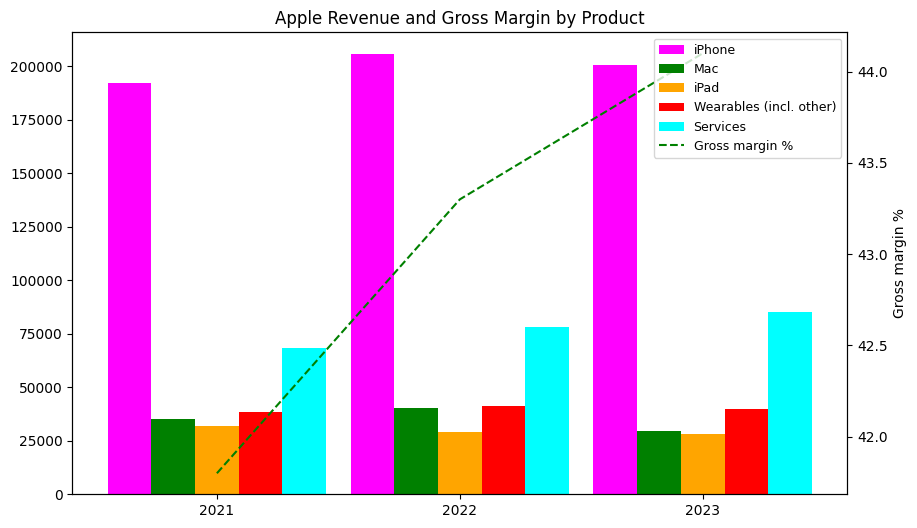

In [ ]:
# It didn't generate the chart I wanted - perhaps I needed to be more specific. Slightly modified code to generate the chart

import matplotlib.pyplot as plt
import numpy as np

# Sample data
products = ['iPhone', 'Mac', 'iPad', 'Wearables (incl. other)', 'Services']
revenue_2021 = [191973, 35190, 31862, 38367, 68425]
revenue_2022 = [205489, 40177, 29292, 41241, 78129]
revenue_2023 = [200583, 29357, 28300, 39845, 85200]
years = ['2021', '2022', '2023']

#adjusting data

revenue_iphone = [revenue_2021[0], revenue_2022[0], revenue_2023[0]]
revenue_mac = [revenue_2021[1], revenue_2022[1], revenue_2023[1]]
revenue_ipad = [revenue_2021[2], revenue_2022[2], revenue_2023[2]]
revenue_wearable = [revenue_2021[3], revenue_2022[3], revenue_2023[3]]
revenue_services = [revenue_2021[4], revenue_2022[4], revenue_2023[4]]
gross_margin_pct = [41.8, 43.3, 44.1]

# Create bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(years))
width = 0.18

# Create bars for each product
bars_iphone = plt.bar(x - width*2, revenue_iphone, width, label=products[0], color='magenta')
bars_mac = plt.bar(x - width, revenue_mac, width, label=products[1], color='green')
bars_ipad = plt.bar(x, revenue_ipad, width, label=products[2], color='orange')
bars_wearable = plt.bar(x + width, revenue_wearable, width, label=products[3],color='red')
bars_services = plt.bar(x + width*2, revenue_services, width, label=products[4],color='cyan')

#plt.legend()

# Create line for secondary axis data
secondary_axis = plt.twinx()  # Create a twin axis
secondary_axis.plot(x, gross_margin_pct, linestyle='--', color='green', label='Gross margin %')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Revenue ($)')
secondary_axis.set_ylabel('Gross margin %')
plt.title('Apple Revenue and Gross Margin by Product')

# Set x-axis ticks and labels
plt.xticks(x, years, rotation=0)

# Add legend
legend_elements = [bars_iphone[0], bars_mac[0], bars_ipad[0], bars_wearable[0], bars_services[0],
                   secondary_axis.lines[0]]
labels = [products[0], products[1], products[2], products[3], products[4], "Gross margin %"]
plt.legend(legend_elements, labels, loc ='upper right', fontsize=9)

# Show the graph
plt.show()
